In [1]:
import sys
from pathlib import Path

# Add parent directory to Python path
parent_dir = Path('.').absolute().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

In [2]:
import os
import pandas as pd
import torch
from transformers import (
    WhisperProcessor,
    WhisperForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
)

from datasets import Dataset, DatasetDict, Audio

DATASET_DIR = "../datasets"
DATASET_PATH = os.path.join(DATASET_DIR, "combined__case_sensitive.csv")
SEED = 137

OUTPUT_DIR = "../outputs"
PROCESSED_DATASET_DIR = os.path.abspath(os.path.join(OUTPUT_DIR, "processed_uzbek_asr_dataset"))
LOGS_DIR = os.path.abspath(os.path.join(OUTPUT_DIR, "logs"))
MODEL_CHECKPOINTS_PATH = os.path.abspath(os.path.join(OUTPUT_DIR, "whisper-uzbek-small"))
FINAL_MODEL_PATH = os.path.abspath(os.path.join(OUTPUT_DIR, "whisper-uzbek-final"))

MODEL_NAME = "openai/whisper-small"

In [3]:
import psutil

# Get virtual memory statistics
mem = psutil.virtual_memory()

print(f"Total System Memory (RAM): {mem.total / (1024 ** 3):.2f} GB")
print(f"Available:                 {mem.available / (1024 ** 3):.2f} GB")
print(f"Used:                      {mem.used / (1024 ** 3):.2f} GB")
print(f"Percentage:                {mem.percent}%")

# Check CUDA availability
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    print(f"✓ GPU available: {torch.cuda.get_device_name(device)}")
    print(f"✓ GPU memory: {torch.cuda.get_device_properties(device).total_memory / 1e9:.2f} GB")

    # Check available memory
    print(f"✓ Memory allocated: {torch.cuda.memory_allocated(device) / 1e9:.2f} GB")
    print(f"✓ Memory reserved: {torch.cuda.memory_reserved(device) / 1e9:.2f} GB")

    # A6000 48GB GPU specific optimizations
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    print("✓ CUDA optimizations enabled")
else:
    print("⚠ No GPU found, training will be VERY slow!")
    print("  Consider using Google Colab or similar if no GPU available")

Total System Memory (RAM): 503.67 GB
Available:                 400.86 GB
Used:                      102.81 GB
Percentage:                20.4%
✓ GPU available: NVIDIA RTX A6000
✓ GPU memory: 50.91 GB
✓ Memory allocated: 0.00 GB
✓ Memory reserved: 0.00 GB
✓ CUDA optimizations enabled


## Prepare Dataset

In [4]:
df = pd.read_csv(DATASET_PATH, index_col="id", low_memory=False)

df["type"] = df["type"].replace("dev", "validation")

# Just for testing the pipeline, get the smaller subset
# Extract Common Voice ~ 9.5 hours of training data
# common_voice_mask = df["dataset"] == "common_voice"
# df = df[common_voice_mask]

# Shuffle dataset
df = df.sample(frac=1, random_state=SEED)

# Create full absolute path to audio
df["path"] = df.apply(
    lambda row: os.path.abspath(
        os.path.join(DATASET_DIR, row["dataset"], "sampled_audio", row["path"])
    ),
    axis=1
)

# Remove unnecessary columns
cols = ["path", "type", "dataset", "duration", "ref_normalized"]
df = df[cols]

print("Dataset Statistics:")
print(f"  Total duration: {df['duration'].sum() / 3600:.2f} hours")
print(f"  Avg duration: {df['duration'].mean():.2f} seconds")
print(f"  By Dataset:")
print((df.groupby(["dataset", "type"])["duration"].sum() / 3600))
print(f"Total training samples: {len(df[df["type"] == "train"]):,}")
print(f"Total validation samples: {len(df[df["type"] == "validation"]):,}")
print(f"Total test samples: {len(df[df["type"] == "test"]):,}")

df.to_csv(os.path.join(DATASET_DIR, "combined_dataset.csv"), index_label="id")
df

Dataset Statistics:
  Total duration: 182.87 hours
  Avg duration: 5.95 seconds
  By Dataset:
dataset        type      
common_voice   test            2.751890
               train           9.617642
               validation      1.328719
feruza_speech  test            0.399899
               train           3.568746
               validation      0.425895
it             test            0.496710
               train           3.950023
               validation      0.489044
news           test            0.794525
               train           6.156671
               validation      0.538155
uzbek_voice    test           13.565436
               train         124.184217
               validation     14.604499
Name: duration, dtype: float64
Total training samples: 89,188
Total validation samples: 10,517
Total test samples: 10,991


,path,type,dataset,duration,ref_normalized
id,,,,,
13645,/root/uzbek-automatic-speech-recognition/datas...,train,uzbek_voice,5.508,Nima bo'lganda ham g'amxo'rligingizdan minnatd...
105539,/root/uzbek-automatic-speech-recognition/datas...,validation,uzbek_voice,4.680,"Ko'zimni ochdim, biroq hech narsa ko'rinmasdi."
4523,/root/uzbek-automatic-speech-recognition/datas...,train,common_voice,8.856,Apple kompaniya foydalanuvchisi vafot etganda ...
41465,/root/uzbek-automatic-speech-recognition/datas...,train,uzbek_voice,5.400,Barcha mamlakatlar xorijiy investorlar uchun b...
80055,/root/uzbek-automatic-speech-recognition/datas...,validation,uzbek_voice,5.868,Tadqiqotchilar tomirlarni diabetga o'xshash mu...
...,...,...,...,...,...
93515,/root/uzbek-automatic-speech-recognition/datas...,validation,uzbek_voice,5.796,Toshkentlik yosh iste'dod egalari Parijga muha...
66707,/root/uzbek-automatic-speech-recognition/datas...,test,uzbek_voice,6.192,Ekstremistik materiallar bilan to'ldirilgan pl...
53837,/root/uzbek-automatic-speech-recognition/datas...,train,uzbek_voice,5.508,Sirtqi ta'lim shakli uchun qabul parametrlarin...


In [14]:
# Verify all audio files exist
print("Checking audio files...")
missing_files = []
for idx, path in df["path"].items():
    if not os.path.exists(path):
        missing_files.append((idx, path))

if missing_files:
    print(f"⚠ WARNING: {len(missing_files)} audio files not found!")
else:
    print(f"✓ All {len(df)} audio files found")

Checking audio files...
✓ All 110696 audio files found


In [5]:
# Convert to Hugging Face Dataset
ds_dict = DatasetDict({
    "train": Dataset.from_pandas(df[df["type"] == "train"]),
    "test": Dataset.from_pandas(df[df["type"] == "test"]),
    "validation": Dataset.from_pandas(df[df["type"] == "validation"])
})
ds_dict = ds_dict.remove_columns(["type", "duration"])

# Cast the path column to Audio
ds_dict = ds_dict.cast_column("path", Audio(sampling_rate=16_000))

# Rename columns for clarity
ds_dict = ds_dict.rename_column("path", "audio")

ds_dict

DatasetDict({
    train: Dataset({
        features: ['audio', 'dataset', 'ref_normalized', 'id'],
        num_rows: 89188
    })
    test: Dataset({
        features: ['audio', 'dataset', 'ref_normalized', 'id'],
        num_rows: 10991
    })
    validation: Dataset({
        features: ['audio', 'dataset', 'ref_normalized', 'id'],
        num_rows: 10517
    })
})

In [6]:
processor = WhisperProcessor.from_pretrained(MODEL_NAME, language="uz", task="transcribe")
model = WhisperForConditionalGeneration.from_pretrained(MODEL_NAME)

model.generation_config.language = "uz"
model.generation_config.task = "transcribe"

# Force decoder to generate in Uzbek
model.config.forced_decoder_ids = processor.get_decoder_prompt_ids(
    language="uz",
    task="transcribe"
)

# Set pad token to avoid attention mask warning
if processor.tokenizer.pad_token_id is None:
    processor.tokenizer.pad_token_id = processor.tokenizer.eos_token_id

# Disable cache for training (saves memory)
# model.config.use_cache = False

print(processor.feature_extractor)
model

WhisperFeatureExtractor {
  "chunk_length": 30,
  "dither": 0.0,
  "feature_extractor_type": "WhisperFeatureExtractor",
  "feature_size": 80,
  "hop_length": 160,
  "n_fft": 400,
  "n_samples": 480000,
  "nb_max_frames": 3000,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "WhisperProcessor",
  "return_attention_mask": false,
  "sampling_rate": 16000
}



WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 768)
      (layers): ModuleList(
        (0-11): 12 x WhisperEncoderLayer(
          (self_attn): WhisperAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (f

In [7]:
from datasets import load_from_disk


def prepare_dataset_for_training(batch):
    """Preprocess a batch for training"""
    # Load and process audio from the 'audio' column
    audios = batch["audio"]

    # Compute log-Mel input features
    input_features = processor.feature_extractor(
        [audio["array"] for audio in audios],
        sampling_rate=audios[0]["sampling_rate"]
    ).input_features

    # Use __call__ method (faster) - just call the tokenizer directly
    encoded = processor.tokenizer(
        batch["ref_normalized"],
        truncation=True,
        padding=False  # Don't pad here, let data collator handle it
    )

    return {
        "input_features": input_features,
        "labels": encoded.input_ids,  # Extract input_ids from the result
        "dataset": batch["dataset"]  # As metadata for evaluation
    }
    # audio = batch["audio"]
    # batch["input_features"] = processor.feature_extractor(
    #     audio["array"],
    #     sampling_rate=audio["sampling_rate"]
    # ).input_features[0]
    #
    # # Encode target text to label ids
    # # batch["labels"] = processor.tokenizer(batch["ref_normalized"]).input_ids
    # batch["labels"] = processor.tokenizer.encode(batch["ref_normalized"])
    #
    # return batch


# Load the existing preprocessed dataset if it exists AND is not empty
if os.path.exists(PROCESSED_DATASET_DIR) and os.path.isfile(os.path.join(PROCESSED_DATASET_DIR, "dataset_dict.json")):
    print(f"--- Found existing processed dataset at {PROCESSED_DATASET_DIR} ---")
    print("Loading from disk to save time...")
    dataset = load_from_disk(PROCESSED_DATASET_DIR)
    print("✓ Preprocessed dataset loaded from disk!")
else:
    print(f"--- Processed dataset not found or incomplete at {PROCESSED_DATASET_DIR} ---")
    print("Starting the heavy preprocessing (this will take a while)...")

    # Map the function over the dataset
    dataset = ds_dict.map(
        prepare_dataset_for_training,
        batched=True,
        batch_size=32,
        num_proc=16,  # processes to use for multiprocessing
        desc="Processing audio",
    )
    dataset.save_to_disk(PROCESSED_DATASET_DIR)
    print("✓ Processed dataset saved to disk!")

print(f"✓ Preprocessed {len(dataset['train'])} training samples")
print(f"✓ Preprocessed {len(dataset['validation'])} validation samples")
print(f"✓ Preprocessed {len(dataset['test'])} test samples")

# Show sample
print("\nSample processed data:")
sample = dataset["train"][0]
print(f"  Input features shape: {len(sample['input_features'])}")
print(f"  Labels length: {len(sample['labels'])}")
print(f"  First few label IDs: {sample['labels'][:10]}")

--- Found existing processed dataset at /root/uzbek-automatic-speech-recognition/outputs/processed_uzbek_asr_dataset ---
Loading from disk to save time...


Loading dataset from disk:   0%|          | 0/172 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/22 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/21 [00:00<?, ?it/s]

✓ Preprocessed dataset loaded from disk!
['input_features', 'labels', 'dataset']
✓ Preprocessed 89188 training samples
✓ Preprocessed 10517 validation samples
✓ Preprocessed 10991 test samples

Sample processed data:
  Input features shape: 80
  Labels length: 42
  First few label IDs: [50258, 50337, 50359, 50363, 45, 4775, 748, 6, 75, 70]


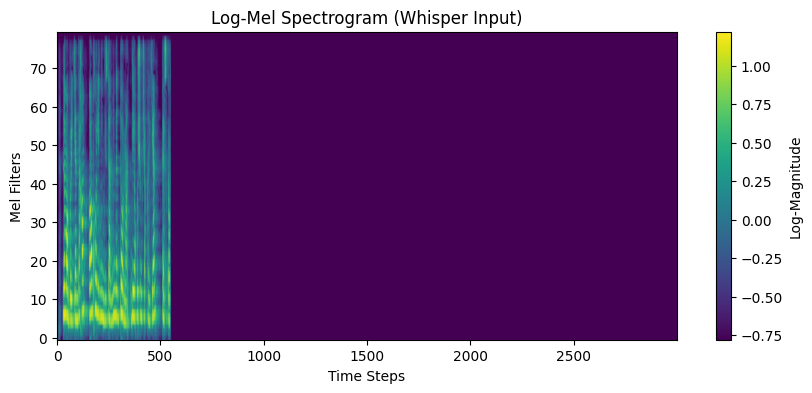

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Convert list to numpy array
spectrogram = np.array(sample["input_features"])

plt.figure(figsize=(10, 4))
plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
plt.title("Log-Mel Spectrogram (Whisper Input)")
plt.ylabel("Mel Filters")
plt.xlabel("Time Steps")
plt.colorbar(label="Log-Magnitude")
plt.show()

In [9]:
from scripts import similarity_metrics


def compute_metrics(pred):
    """
    Compute metrics using Uzbek text normalizer
    Reports both normalized and raw WER
    """
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # Replace -100 with pad token id
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # Decode predictions and labels in batch (more efficient)
    preds_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    # Return corpus-level (macro-averaging) metrics
    return similarity_metrics.calculate(labels_str, preds_str)

In [10]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # Split inputs and labels
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        # Pad input features
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # Pad labels
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # Replace padding with -100 to ignore loss
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # Remove BOS token if present
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch


data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [ ]:
def train_model(model, processor, dataset):
    """
    Main training function

    Args:
        model: Whisper model
        processor: WhisperProcessor
        dataset: Prepared dataset

    Returns:
        Trained model
    """
    print("\n" + "=" * 50)
    print("TRAINING")
    print("=" * 50)

    # Define training arguments
    training_args = Seq2SeqTrainingArguments(
        output_dir=os.path.join(OUTPUT_DIR, "whisper-uzbek-small"),  # Where to save the model

        # TODO: change for full dataset: save_steps, eval_steps, warmup_steps
        # Model checkpointing
        save_total_limit=3,  # Keep only 3 best checkpoints
        save_strategy="steps",
        save_steps=800,  # Save checkpoint every 800 steps (~ 2.3x per epoch)
        eval_strategy="steps",
        eval_steps=800,  # Save checkpoint every 800 steps (~ 2.3x per epoch)
        load_best_model_at_end=True,
        metric_for_best_model="wer",  # Primary metric
        greater_is_better=False,  # Lower WER is better

        # Batch size - optimized for A6000 48GB
        # Effective batch size = per_device_train_batch_size * gradient_accumulation_steps = 48
        per_device_train_batch_size=48,
        gradient_accumulation_steps=1,  # If you have smaller VRAM, you can simulate larger batch size
        per_device_eval_batch_size=256,  # Can be larger for eval (no gradients)

        # Learning rate and schedule
        learning_rate=1e-5,
        warmup_steps=500,
        weight_decay=0.01,  # Add L2 regularization
        max_grad_norm=1.0,  # Gradient clipping

        # Training duration
        num_train_epochs=5,  # Number of times to go through dataset
        max_steps=-1,  # Train for full epochs

        # Memory optimization
        gradient_checkpointing=False,
        # Use gradient checkpointing to save memory at the expense of slower backward pass
        fp16=True,  # Use mixed precision for faster training
        fp16_full_eval=False,  # Use FP32 for eval (more stable)
        dataloader_num_workers=8,  # Parallel data loading
        dataloader_pin_memory=True,  # Faster GPU transfer

        # Generation settings
        predict_with_generate=True,  # Generate during eval
        generation_max_length=225,  # Token generation limit for a 30-second audio chunk
        generation_num_beams=1,
        # Model keeps track of n possible sentences at once (choose 1 for speed and less memory usage)

        # Logging
        logging_dir=LOGS_DIR,
        logging_steps=50,  # More frequent logging
        logging_strategy="steps",
        logging_first_step=True,
        report_to=["tensorboard"],

        push_to_hub=False,  # Set True to share on Hugging Face
        remove_unused_columns=False,  # Keep metadata columns
        seed=SEED,  # Use SEED for any random events
    )

    print("\n📊 Training Configuration:")
    print(f"  Output: {training_args.output_dir}")
    print(f"  Batch size: {training_args.per_device_train_batch_size}")
    print(f"  Gradient accumulation: {training_args.gradient_accumulation_steps}")
    print(
        f"  Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
    print(f"  Learning rate: {training_args.learning_rate}")
    print(f"  Epochs: {training_args.num_train_epochs}")
    print(f"  FP16: {training_args.fp16}")
    print(f"  Gradient checkpointing: {training_args.gradient_checkpointing}")

    # Calculate training steps
    steps_per_epoch = len(dataset["train"]) // (
            training_args.per_device_train_batch_size *
            training_args.gradient_accumulation_steps
    )
    total_steps = steps_per_epoch * training_args.num_train_epochs

    print(f"\n📈 Training Schedule:")
    print(f"  Steps per epoch: {steps_per_epoch}")
    print(f"  Total steps: {total_steps}")
    print(f"  Warmup steps: {training_args.warmup_steps}")
    print(f"  Eval frequency: every {training_args.eval_steps} steps")
    print(f"  Save frequency: every {training_args.save_steps} steps")

    # Initialize data collator
    data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)
    print("✓ Initialized data collator")

    # Initialize trainer
    trainer = Seq2SeqTrainer(
        args=training_args,
        model=model,
        train_dataset=dataset["train"],
        eval_dataset=dataset["validation"],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        processing_class=processor.feature_extractor,
    )
    print("✓ Initialized trainer")

    # Train
    print("\n🚀 Starting training...")
    print(f"Monitor: tensorboard --logdir {LOGS_DIR}\n")
    print("=" * 50)

    try:
        train_result = trainer.train()

        # Save final model
        trainer.save_model(FINAL_MODEL_PATH)
        processor.save_pretrained(FINAL_MODEL_PATH)

        print("\n" + "=" * 50)
        print("TRAINING COMPLETED!")
        print("=" * 50)
        print(f"Final metrics:")
        print(f"  Training loss: {train_result.training_loss:.4f}")
        print(f"  Training time: {train_result.metrics['train_runtime'] / 3600:.2f} hours")
        print(f"  Samples per second: {train_result.metrics['train_samples_per_second']:.2f}")

        # Shows the highest amount of VRAM used since the script started
        peak_mem = torch.cuda.max_memory_allocated(device) / 1e9
        print(f"\nPeak GPU memory usage: {peak_mem:.2f} GB")

        return model, trainer

    except KeyboardInterrupt:
        print("\n\nTraining interrupted by user!")
        print("Saving checkpoint...")
        trainer.save_model(os.path.join(OUTPUT_DIR, "interrupted_checkpoint"))
        raise
    except Exception as e:
        print(f"\n\nError during training: {e}")
        raise


model, trainer = train_model(model, processor, dataset)


TRAINING

📊 Training Configuration:
  Output: ../outputs/whisper-uzbek-small
  Batch size: 48
  Gradient accumulation: 1
  Effective batch size: 48
  Learning rate: 1e-05
  Epochs: 5
  FP16: True
  Gradient checkpointing: False

📈 Training Schedule:
  Steps per epoch: 1858
  Total steps: 9290
  Warmup steps: 500
  Eval frequency: every 800 steps
  Save frequency: every 800 steps
✓ Initialized data collator
✓ Initialized trainer

🚀 Starting training...
Monitor: tensorboard --logdir /root/uzbek-automatic-speech-recognition/outputs/logs



Step,Training Loss,Validation Loss,Wer,Cer,Sequence Similarity,Wer Raw,Cer Raw,Sequence Similarity Raw
800,0.115200,0.197660,0.170100,0.041800,0.951200,0.207800,0.048000,0.945100
1600,0.142000,0.149087,0.128100,0.033100,0.957400,0.164800,0.039100,0.951300
2400,0.070500,0.132703,0.115100,0.029500,0.962900,0.150200,0.035200,0.955700
3200,0.066000,0.122704,0.104900,0.026000,0.963900,0.139000,0.031700,0.957700
4000,0.035000,0.120633,0.099100,0.025000,0.965000,0.132700,0.030600,0.958000
4800,0.032100,0.117709,0.097000,0.025100,0.967800,0.129400,0.029600,0.961400
5600,0.024600,0.116754,0.096300,0.025100,0.967300,0.127700,0.029500,0.961200
6400,0.016200,0.119226,0.092400,0.023400,0.967800,0.124700,0.028700,0.959800
7200,0.015500,0.119070,0.093400,0.023700,0.967500,0.125700,0.029000,0.959900
8000,0.007100,0.124549,0.092000,0.023200,0.968700,0.124000,0.028400,0.960800


While converting '123 600 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000' to number, IndexError error occurred: list index out of range
While converting '123 600 000 000 000 0

While converting '123 001 0725 0621 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 00' to number, IndexError error occurred: list index out of range


While converting '123 600 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000' to number, IndexError error occurred: list index out of range


While converting '123 006 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 040 525 0' to number, IndexError error occurred: list index out of range


While converting '123 001 020 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000' to number, IndexError error occurred: list index out of range


While converting '123 001 020 000 000 400 755 040 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000' to number, IndexError error occurred: list index out of range


While converting '123 600 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000' to number, IndexError error occurred: list index out of range
While converting '123 001 024 025 030 0

While converting '123 001 020 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000' to number, IndexError error occurred: list index out of range


While converting '123 001 020 000 000 07500 000 05 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 00' to number, IndexError error occurred: list index out of range
While converting '123 001 024 025 030 030 030 040 045 045 045 047 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 0' to number,

There were missing keys in the checkpoint model loaded: ['proj_out.weight'].



TRAINING COMPLETED!
Final metrics:
  Training loss: 0.0559
  Training time: 4.51 hours
  Samples per second: 27.47

Peak GPU memory usage: 48.29 GB


In [17]:
def print_evaluation_results(metrics: dict, dataset_name: str = "VALIDATION"):
    """
    Print formatted evaluation metrics.

    Args:
        metrics: Dictionary of metrics from trainer.evaluate()
        dataset_name: Name of the dataset being evaluated (e.g., "VALIDATION", "TEST")
    """
    print(f"\n{'=' * 50}")
    print(f"DETAILED EVALUATION: {dataset_name.upper()}")
    print(f"{'=' * 50}")
    print(f"{'Metric':<25} {'Value':>10}")
    print("-" * 50)
    print(f"{'WER (normalized)':<25} {metrics['eval_wer'] * 100:>9.2f}%")
    print(f"{'CER (normalized)':<25} {metrics['eval_cer'] * 100:>9.2f}%")
    print(f"{'Sequence Similarity':<25} {metrics['eval_sequence_similarity'] * 100:>9.2f}%")
    print(f"{'WER (raw)':<25} {metrics['eval_wer_raw'] * 100:>9.2f}%")
    print(f"{'CER (raw)':<25} {metrics['eval_cer_raw'] * 100:>9.2f}%")
    print(f"{'Seq Similarity (raw)':<25} {metrics['eval_sequence_similarity_raw'] * 100:>9.2f}%")
    print("=" * 50 + "\n")


# Evaluate validation set
val_metrics = trainer.evaluate(dataset["validation"])
print_evaluation_results(val_metrics, "validation")

# Evaluate test set
test_metrics = trainer.evaluate(dataset["test"])
print_evaluation_results(test_metrics, "test")

While converting '123 001 020 000 000 07500 000 05 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 00' to number, IndexError error occurred: list index out of range
While converting '123 001 024 025 030 030 030 040 045 045 045 047 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 0' to number,


DETAILED EVALUATION: TEST
Metric                         Value
--------------------------------------------------
WER (normalized)              10.19%
CER (normalized)               2.53%
Sequence Similarity           96.54%
WER (raw)                     13.25%
CER (raw)                      3.02%
Seq Similarity (raw)          96.11%



In [11]:
from scripts.whisper_utils import load_model, evaluate_by_dataset

final_model, final_trainer, final_processor = load_model(FINAL_MODEL_PATH, dataset, data_collator)
evaluate_by_dataset(final_trainer, final_processor, dataset["validation"], "validation")
evaluate_by_dataset(final_trainer, final_processor, dataset["test"], "test")

You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenize

While converting '123 001 020 000 000 07500 000 05 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 001 00' to number, IndexError error occurred: list index out of range
While converting '123 001 024 025 030 030 030 040 045 045 045 047 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 050 0' to number,


DETAILED EVALUATION: TEST

OVERALL METRICS
--------------------------------------------------------------------------------
WER (normalized)              10.19%
CER (normalized)               2.53%
Sequence Similarity           96.54%
WER (raw)                     13.25%
CER (raw)                      3.02%
Seq Similarity (raw)          96.11%

METRICS BY DATASET

common_voice
--------------------------------------------------------------------------------
WER (normalized)              10.58%
CER (normalized)               2.47%
Sequence Similarity           98.16%
WER (raw)                     14.13%
CER (raw)                      3.05%
Seq Similarity (raw)          97.76%

feruza_speech
--------------------------------------------------------------------------------
WER (normalized)              10.52%
CER (normalized)               1.81%
Sequence Similarity           96.17%
WER (raw)                     16.87%
CER (raw)                      2.82%
Seq Similarity (raw)          94.99

In [12]:
from scripts.whisper_utils import load_checkpoint, evaluate_by_dataset

check_9295_model, check_9295_trainer, check_9295_processor = load_checkpoint(
    os.path.join(MODEL_CHECKPOINTS_PATH, "checkpoint-9295"),
    dataset,
    data_collator,
    base_model_name="openai/whisper-small"
)
evaluate_by_dataset(check_9295_trainer, check_9295_processor, dataset["validation"], "validation")
evaluate_by_dataset(check_9295_trainer, check_9295_processor, dataset["test"], "test")

You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenize

While converting '123 001 020 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000' to number, IndexError error occurred: list index out of range
While converting '123 001 024 025 030 030 030 0


DETAILED EVALUATION: TEST

OVERALL METRICS
--------------------------------------------------------------------------------
WER (normalized)              10.18%
CER (normalized)               2.52%
Sequence Similarity           96.56%
WER (raw)                     13.27%
CER (raw)                      3.02%
Seq Similarity (raw)          96.08%

METRICS BY DATASET

common_voice
--------------------------------------------------------------------------------
WER (normalized)              10.63%
CER (normalized)               2.48%
Sequence Similarity           98.15%
WER (raw)                     14.17%
CER (raw)                      3.06%
Seq Similarity (raw)          97.75%

feruza_speech
--------------------------------------------------------------------------------
WER (normalized)              10.20%
CER (normalized)               1.76%
Sequence Similarity           96.21%
WER (raw)                     16.61%
CER (raw)                      2.77%
Seq Similarity (raw)          95.20

In [19]:
def test_model(model_path: str, audio_file: str):
    """
    Test the fine-tuned model on a sample audio file

    Args:
        model_path: Path to fine-tuned model
        audio_file: Path to audio file to transcribe
    """
    print("\n" + "=" * 50)
    print("TESTING MODEL")
    print("=" * 50)

    from transformers import pipeline

    # Load model
    pipe = pipeline(
        "automatic-speech-recognition",
        model=model_path,
        device=0 if torch.cuda.is_available() else -1
    )

    print(f"✓ Loaded model from {model_path}")
    print(f"✓ Processing: {audio_file}")

    # Transcribe
    result = pipe(audio_file, language="uz", task="transcribe")

    print(f"\nTranscription: {result['text']}")

    return result


test_audio = os.path.join(DATASET_DIR, "devona_sample.wav")
if os.path.exists(test_audio):
    test_model(FINAL_MODEL_PATH, test_audio)


TESTING MODEL


Device set to use cuda:0


✓ Loaded model from ../outputs/whisper-uzbek-final
✓ Processing: ../datasets/devona_sample.wav

Transcription: Har kuni ertalab quyosh chiqayotganida uydan chiqargan. Oldin eshik oldida turib atrofga uzoq tikilar. Keyin qo'llarini, ko'zlarini va qalbini samoga yo'naltirib, va dud, yo va dud deb baqirardi.
